In [10]:
import pandas as pd
import cobra
import driven
import numpy as np
from driven.data_sets import ExpressionProfile
from pickle import load
import json
import matplotlib

fname = '../data/nobori_2018/pnas.1800529115.sd02.xlsx'
conditions = ['MM','vivo','flg22','D36E','AvrRpt2','AvrRps4']
all_conditions_frames = []
condition_to_p = {}
# load the up and down sheet for each comparison, then merge
# them into a single dataframe and rename the columns to meet the
# conventions in the driven package.
for condition in conditions:
    down = pd.read_excel(fname,sheet_name=condition+"_down")
    down = down.rename({condition+'_down':'gene'},axis='columns')
    up = pd.read_excel(fname,sheet_name=condition+"_up")
    up = up.rename({condition+'_up':'gene'},axis='columns')
    both = pd.concat([down,up])
    fchange_col = both.columns
    expression_column = [c for c in both.columns if "fold change" in c][0]
    p_column = [c for c in both.columns if "q-value" in c][0]
    condition = expression_column.split(': ')[1]
    
    both = both.rename({p_column:\
        "p-value-"+condition,expression_column:condition},axis='columns')
    
    # split each gene name by '-' to get the KEGG gene ID only,
    # then reassign it to the index
    new_index = [s[0] for s in both['gene'].str.split('-')]
    both.index = new_index
    both = both.drop('gene',axis=1)
    all_conditions_frames.append(both)
    
    # save the exact condition name and the p value column associated with it
    condition_to_p[condition] = "p-value-"+condition
xomics_data = pd.concat(all_conditions_frames,axis=1)

# for p-value columns that are NaN after the merge, reassign as 1 to indicate
# not significant
p_cols = [c for c in xomics_data.columns if "p-value" in c]
xomics_data[p_cols] = xomics_data[p_cols].fillna(value=1.0)

# for expression, do the equivalent (set foldchange to 0)
diff_cols = [c for c in xomics_data.columns if "p-value" not in c]
xomics_data[diff_cols] = xomics_data[diff_cols].fillna(value=0.0)


# Load the count data
fname = "../data/nobori_2018/GSE103441_count.txt"
count_frame = pd.read_csv(fname,sep='\t',index_col=0)
# remove sample names from the end of column names
# and merge samples group-wise into a mean
#'_'.join(count_frame.columns[0].split('_')[:-1])
groups = set(['_'.join(c.split('_')[:-1]) for c in count_frame.columns])
mean_count_frame = pd.DataFrame(index=count_frame.index)
group_to_samples = {}
for group in groups:
    samps = [col for col in count_frame.columns if group in col]
    group_to_samples[group] = samps
    # normalize to transcripts per million within each sample
    mean = count_frame[samps].divide(count_frame[samps].sum()/1E6).mean(axis=1)
    mean_count_frame[group] = mean
    
    
# extract the groups of interest from count frame
flg_v_mock_counts = mean_count_frame[['Pto_col_mock','Pto_col_flg22']]
flg_v_mm_counts = mean_count_frame[["Pto_col_flg22", "Pto_MM_A80"]]
# replace A in the gene names with _ as in the other
# spreadsheets provided by the author
#the following line is not necessary because PSPTO_0001 and PSPTOA0001 are different genes, changed to 
#replace "A" with "_A" like plasmid B
flg_v_mock_counts.index = flg_v_mock_counts.index.str.replace('A','_A')
flg_v_mm_counts.index = flg_v_mm_counts.index.str.replace('A', "_A")
# add p-values
flg_v_mock_p = xomics_data["p-value-flg22_Pto - Mock_Pto"]
flg_v_mock_counts['p-value'] = flg_v_mock_p
flg_v_mock_counts = flg_v_mock_counts.fillna(1)

# rename the gene identifiers by splitting at "-" to only include the actual identifiers,
# not the descriptions.
identifiers = [gene.split('-')[0] for gene in flg_v_mock_counts.index.tolist()]

flg_v_mock_exp_prof = ExpressionProfile(identifiers=identifiers,
                                        conditions=['Pto_col_mock','Pto_col_flg22'],
                                        expression=flg_v_mock_counts[['Pto_col_mock','Pto_col_flg22']].values,
                                        p_values=np.reshape(flg_v_mock_counts['p-value'].values,(-1, 1)))



/Users/glm5uh/anaconda3/envs/driven_devel/lib/python3.7/site-packages/ipykernel_launcher.py:40 FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/glm5uh/anaconda3/envs/driven_devel/lib/python3.7/site-packages/ipykernel_launcher.py:80 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# load the medusa ensemble
import medusa
with open('../results/ensembles/psy_ensemble_100_for_analysis.pickle', 'rb') as infile:
    ensemble = load(infile)
    


In [12]:
ensemble.base_model


Name,PST
Memory address,0x0126813da0
Number of metabolites,1224
Number of reactions,1439
Number of groups,58
Objective expression,1.0*bio1 - 1.0*bio1_reverse_b18f7
Compartments,"c, e"


Pto_col_mock                          297.386577
Pto_col_flg22                         265.865424
Pto_col_mock Pto_col_flg22 p-value      1.000000
dtype: float64

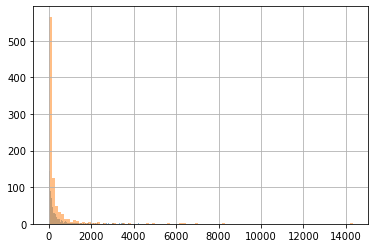

In [13]:



# plot the distribution of transcripts for genes that are in the model
transcripts_in_model = list(set(flg_v_mock_exp_prof.identifiers).intersection(set(
                        [g.id for g in ensemble.base_model.genes])))


flg_v_mock_exp_prof.data_frame.loc[transcripts_in_model]['Pto_col_flg22'].hist(bins = 100, alpha = 0.5)
flg_v_mock_exp_prof.data_frame.loc[transcripts_in_model]['Pto_col_mock'].hist(bins = 100, alpha = 0.5)

mock_mean = flg_v_mock_exp_prof.data_frame.loc[transcripts_in_model].mean()['Pto_col_mock']
flg_mean = flg_v_mock_exp_prof.data_frame.loc[transcripts_in_model].mean()['Pto_col_flg22']
avg2x = (mock_mean + flg_mean)*2

flg_v_mock_exp_prof.data_frame.loc[transcripts_in_model].mean()

In [14]:
#apply gimme to all the ensemble members and save the solutions
mock_solutions = {}
flg_solutions = {}

cutoff = avg2x

member_count = 0
for member in ensemble.members:
    member_count += 1
    print(member_count)
    #if member_count is not 71: # GIMME hangs on this model. Seems to get stuck at solver; kernel interrupt doesn't work
    ensemble.set_state(member)
    model, mock_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_mock',
                                                       cutoff=cutoff,fraction_of_optimum=0.05)
    model, flg_solutions[member.id] = driven.gimme(ensemble.base_model,flg_v_mock_exp_prof,condition = 'Pto_col_flg22',
                                                       cutoff=cutoff,fraction_of_optimum=0.05)

# save the fluxes from each solution    
pd.DataFrame([mock_solutions[member].fluxes for member in mock_solutions.keys()]).to_csv('../results/gimme/mock_gimme_tpm_fluxes.tsv',sep='\t')
pd.DataFrame([flg_solutions[member].fluxes for member in flg_solutions.keys()]).to_csv('../results/gimme/flg_gimme_tpm_fluxes.tsv',sep='\t')


# for each gimme solution, get the list of open reactions.
def get_open_reactions(gimme_solution):
    open_reactions = []
    for reaction in gimme_solution.fluxes.keys():
        if abs(gimme_solution.fluxes[reaction]) > 0:
            open_reactions.append(reaction)
    return open_reactions

mock_open_reactions = {}
flg_open_reactions = {}
for member_id in mock_solutions.keys():
    mock_open_reactions[member_id] = get_open_reactions(mock_solutions[member_id])
    flg_open_reactions[member_id] = get_open_reactions(flg_solutions[member_id])
    
# save the open reactions
with open('../results/gimme/mock_gimme_open_reactions_cutoff4.json', 'w') as outfile:
    json.dump(mock_open_reactions,outfile)
with open('../results/gimme/flg_gimme_open_reactions_cutoff4.json', 'w') as outfile:
    json.dump(flg_open_reactions,outfile)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
